# ROOT
Root è un framework dotato di routine di analisi dati, statistica, grafici e metodi avanzati di input/output

Root ha un interprete built-in (cling) che in realtà è un just in time compiler ed è dotato di un wrapper python

## I/O
Le informazioni vengono salvatge e lette in  formato colonnare. Ovvero ogni riga corrisponde a un evento. Un evento può avere un numero arbitrario di particelle a cui sono associati diversi dati (energia, etc.)
In una semplice lista python avremmo un tensore in cui ogni riga possiede un numero di colonne variabile e sarebbe molto difficile da gestire

L'interprete di ROOT supporta dei comandi speciali che hanno come prefisso un punto
- .q: chiudi root
- .! usa comandi di sistema
- .L file_name carica una macro (Per creare una macro basta scrivere un file cpp chiamato Macroname con dentro una funzione MacroName) per poi chiamarla quando si vuole. La macro viene eseguita JIT
- .L file_name+ In questo modo la macro viene compilata e viene generata una shared library
- .help help sui comandi speciali

Per compilare un programma cpp che include pacchetti di root bisogna usare la seguente flag
`root-config --cflags --libs`

## Istogrammi
La classe che gestisce gli istogrammi è TH1. Da questa eredita TH1F (F sta per float) che è la più usata ma anche TH2 e TH3 che è una cosa abbastanza stupida poichè un istogramma 2d o 3d non è un caso particolare di istogramma a una dimensione

Per disegnare un istogramma bisogna creare un'istanza TH1F che ha come parametri("nome_hist","titolo",num_bin,xinf,xsup)

Per mostrarlo bisogna creare un TCanvas ("nome", "titolo",height, width) e poi fare hist.Draw() e  canv.Draw()
(canvas )
**NB In root c'è una variabile interna che si chiama current TCanvas che, a meno che non venga cambiata a mano, corrisponde all'ultima TCanvas creata. Lo stesso vale quando si fa il fill dell'istogramma. (E' una porcheria, non è neanche thread safe)

**NB In una macro è necessario creare TH1F con new allocandolo nell'heap altrimenti come si esce dallo scope della funzione l'istogramma viene distrutto. Ricorda che poi va distrutto. In modalità interattiva si può evitare**

Volendo possiamo riempire l'istogramma con numeri casuali con FillRandom.

### Opzioni sugli istrogrammi
Gli istogrammi possono essere personalizzati sia con altri comani come.SetFillColor(colore), sia passando delle stringhe a .Draw() (Es. "E" per gli errori.Di default root mette errori poissoniani sui bin)
Per disegnare altra roba sopra un istrogramma già esistente bisogna usare l'opzione SAME.  Per usare più opzioni basta attaccare le stringhe insieme senza separatori
Per salvarli si usa il comando .SaveAs(name.png)

Le tabelle riassuntive presenti di default negli istogrammi possono essere modificate usando variabili interne globali come gStyle->SetOptStat() e a questa funzione va passata una sequenza di 0 e 1 per decidere quali info mostrare e quale no

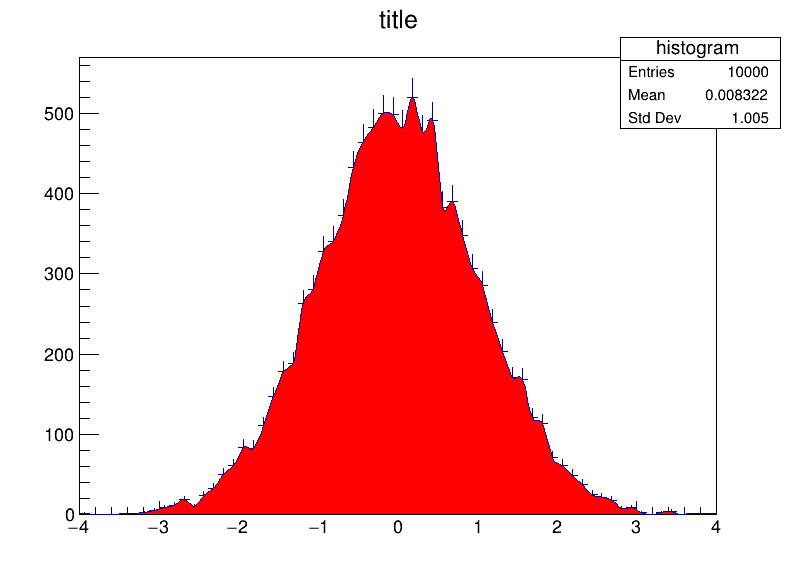

In [2]:
TH1F *hist =new TH1F("histogram","title",64,-4,4);
TCanvas c("myCanvasName","The Canvas Title",800,600);
hist->FillRandom("gaus",10000);

//hist->Draw("E"); //Il comando E disegna istogramma con errori
hist->Draw("E");
hist->SetFillColor(kRed); //riempie istogramma
hist->Draw("SAMEC"); //Ridisegna la stessa cosa ma con una linea continua riempita di rosso
c.Draw();
